# Starfish SeqFISH Spot Detection Workbook

## Process the data as described

In [112]:
%gui qt5

In [113]:
%matplotlib inline

In [114]:
import os
from copy import deepcopy
from itertools import product

import numpy as np
import pandas as pd
import skimage.filters
import skimage.morphology
from skimage.transform import SimilarityTransform, warp
from tqdm import tqdm

import starfish
import starfish.data
from starfish.spots import DetectSpots
from starfish.types import Axes

import matplotlib.pyplot as plt

Select data for a fragment of a single field of view and look at the raw data.

In [177]:
%gui qt5

In [176]:
starfish.display(img)

In [116]:
exp = starfish.Experiment.from_json("/Users/ajc/scratch/seqfish-test/experiment.json")
img = exp['fov_000'].get_image('primary')

starfish.display(img)

100%|██████████| 1740/1740 [00:08<00:00, 194.04it/s]


## Register the Data

The first step in SeqFISH is to do some rough registration. For this data, the rough registration has been done for us by the authors, so it is omitted from this notebook.

## Remove image background

To remove image background, use a White Tophat filter, which measures the background with a rolling disk morphological element and subtracts it from the image. 

In [117]:
from skimage.morphology import opening, dilation, disk
from functools import partial

If desired, the background that is being subtracted can be visualized (note that the opening is not being applied here, but rather as part of the white tophat, below). 

In [118]:
opening = partial(opening, selem=disk(3))

background = img.apply(
    opening,
    group_by={Axes.ROUND, Axes.CH, Axes.ZPLANE}, verbose=False, in_place=False
)

starfish.display(background)

In [119]:
wth = starfish.image.Filter.WhiteTophat(masking_radius=3)
background_corrected = wth.run(img, in_place=False)

starfish.display(background_corrected)

#TODO Think about running a gaussian or median filter to mitigate noise in channel 1 prior to scaling

## Scale images to equalize spot intensities across channels

The number of peaks are not uniform across rounds and channels, which prevents histogram matching across channels. Instead, a percentile value is identified and set as the maximum across channels, and the dynamic range is extended to equalize the channel intensities

In [120]:
def scale_by_percentile(data, p=99.9):
    data = np.asarray(data)
    cval = np.percentile(data, p)
    data = data / cval
    data[data > 1] = 1
    return data

scaled = background_corrected.apply(
    scale_by_percentile,
    group_by={Axes.ROUND, Axes.CH}, verbose=False, in_place=False
)

In [15]:
starfish.display(scaled)

## Detect Spots

Detect spots with a local search blob detector that identifies spots in all rounds and channels and matches them using a local search method. The local search starts in an anchor round (default round=1) and identifies the nearest spot in all subsequent imaging rounds. 

Interestingly, this is not the approach taken by the authors. They do a combined spot finding and decoding approach. Here we build their model, including the relevant statistical null models to evaluate their approach. 

To begin, the authors use a permissive thresholding approach to call _all_ spots, even those likely to be background. The theory is that they can rely upon the decoding to parse which spots are real and which are not. We investigate the statistical implications of this approach. 

Through conversations at the hackathon with an engineer in the Cai lab, we identified a spot finding threshold that he says matches their results.

In [11]:
clip = starfish.image.Filter.Clip(p_min=10)
clipped = clip.run(scaled)
starfish.display(clipped)

The local search blob detector simply runs blob_log on each image, then defines code to identify a particular round as the "anchor" and finds spots within a certain physical distance of the spot. It works great in non-crowded data (see the StarMAP notebook). We'll copy the starfish code here as reference and so we can call pieces of it as needed. 

The Cai lab engineer indicated that the following parameters generate spot calls that match his expectations for how their internal pipelines function. We've previously implemented a `LocalSearchBlobDetector` that does the following: 

1. detects spots in each volume
2. combines the spots detected in all channels across a round
3. selects one round as an "anchor" and uses the physical coordinates of the spots detected in all channels in that round as seeds for barcode detection
4. Finds the closest spot in each non-anchor round (within an outer bound "search radius") to each (z, y, x) spots from the anchor round, and builds a code.
5. Returns an `IntensityTable` containing the discovered codes. 

This approach is taken by StarMAP and we apply that approach here. 

In [159]:
import starfish.util.plot

In [178]:
starfish.display(scaled)

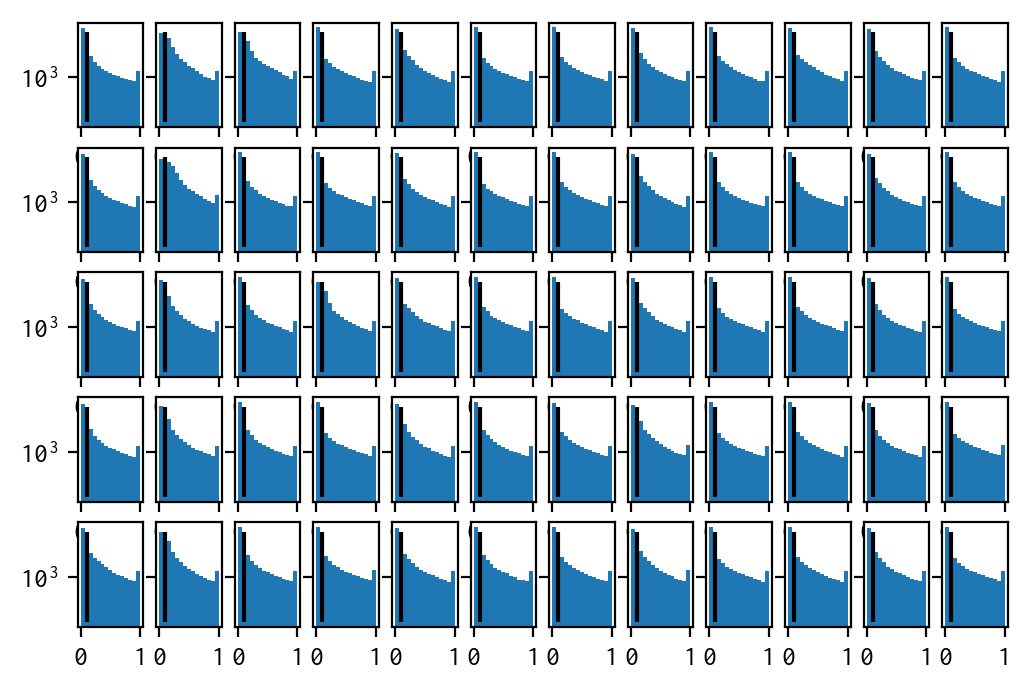

In [173]:
rounds = scaled.xarray.sizes['r']
channels = scaled.xarray.sizes['c']

f, axes = plt.subplots(nrows=5, ncols=12, dpi=200, sharey=True)
for r, c in product(np.arange(rounds), np.arange(channels)): 
    data = np.ravel(scaled.xarray.sel(r=r, c=c).values)
    axes[r, c].hist(data, bins=15, log=True)
    axes[r, c].vlines(0.1, 1, 10**6)
    axes[r, c].set_axis_off()

We're not actually going to use the anchor round capabilities of the Local Search Blob Detector in this notebook, we're just going to use some private methods for matching spots across channels, and we'll implement the for loop across potential anchor rounds to explore how the data look using different "seed positions" for the local search. 

In [184]:
anchors = np.arange(5)
verbose=True
n_processes=None

lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
    min_sigma=(0.9, 0.9, 0.9),
    max_sigma=(5, 5, 5),
    num_sigma=7,
    threshold=0.1,
    search_radius=2.45,
)

The below command finds spots in all rounds and channels

In [185]:
per_tile_spot_results = lsbd._find_spots(
    scaled, 
    verbose=verbose, 
    n_processes=n_processes
)

This command just concatenates all channels within a round, adding a column that records what channel each spot corresponds to

In [186]:
per_round_spot_results = lsbd._merge_spots_by_round(per_tile_spot_results)
print("Completed spot finding")

Completed spot finding


This command loops over the rounds and finds the _single_ nearest neighbor in each other round, by physical distance, excluding all spots outside search_radius. It then creates an IntensityTable from the resulting spots, which may or may not contain a valid code, or even spots in all channels. 

In [188]:
# results dicts
distances = {}
indices = {}
intensity_tables = {}

for anchor_round in anchors:

    dist, ind = starfish.spots.DetectSpots.LocalSearchBlobDetector._match_spots(
        per_round_spot_results,
        search_radius=lsbd.search_radius, anchor_round=anchor_round
    )
    distances[anchor_round] = dist
    indices[anchor_round] = ind

    intensity_tables[anchor_round] = starfish.spots.DetectSpots.LocalSearchBlobDetector._build_intensity_table(
        per_round_spot_results, distances[anchor_round], indices[anchor_round],
        rounds=scaled.xarray[Axes.ROUND.value].values,
        channels=scaled.xarray[Axes.CH.value].values,
        search_radius=lsbd.search_radius,
        anchor_round=anchor_round
    )
    print(f"Completed processing for round {anchor_round}")

Completed processing for round 0
Completed processing for round 1
Completed processing for round 2
Completed processing for round 3
Completed processing for round 4


This cell decodes the spots in each of the intensity tables

In [190]:
decoded = {}
for anchor_round in anchors:
    decoded[anchor_round] = exp.codebook.decode_per_round_max(intensity_tables[anchor_round].fillna(0))
    print(f"decoded round {anchor_round}")

decoded round 0
decoded round 1
decoded round 2
decoded round 3
decoded round 4


What fraction of spots decode in each channel? Remember these numbers. We'll calculate the null model later: assuming random selection of channels, how many spots would decode by chance? 

In [191]:
for a in anchors:
    print(f"fraction decoded spots for round {a}: {float(np.sum(decoded[a].target != 'nan') / decoded[a].shape[0]):.4f}")

fraction decoded spots for round 0: 0.0396
fraction decoded spots for round 1: 0.0408
fraction decoded spots for round 2: 0.0455
fraction decoded spots for round 3: 0.0422
fraction decoded spots for round 4: 0.0387


The data are biased towards decoding spots in channel 1, regardless of the anchor round; this is because that channel is super noisy. (Confirm with Napari)

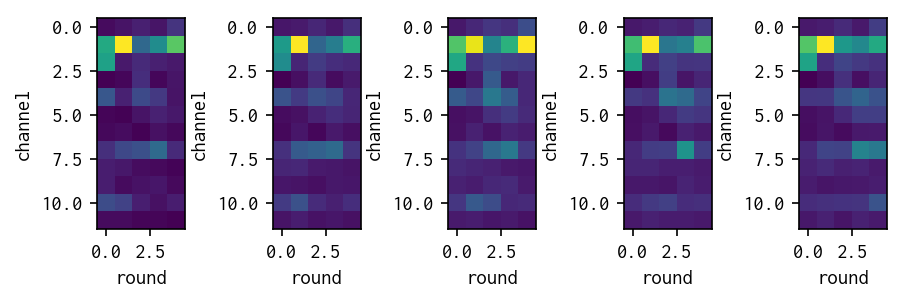

In [25]:
f, axes = plt.subplots(dpi=150, ncols=5, sharex=True)
for a, ax in enumerate(axes):
    num_detected = (decoded[a] != 0).sum('features')
    ax.imshow(num_detected)
    ax.set_xlabel('round')
    ax.set_ylabel('channel')
f.tight_layout()

Nico mentioned that our original notebook was not detecting enough spots. Verify that we've now fixed the problem by building an IntensityTable with all the spots. 

In [199]:
from typing import Dict, Sequence
from starfish import IntensityTable
from starfish.types import Features

In [200]:
# this function is only needed because napari is hard to use outside starfish

def build_intensity_table_all_spots(
    round_dataframes: Dict[int, pd.DataFrame],
    channels: Sequence[int],
    rounds: Sequence[int],
) -> IntensityTable:
    """Construct an intensity table from the results of a local search over detected spots

    Parameters
    ----------
    round_dataframes : Dict[int, pd.DataFrame]
        Output from _merge_spots_by_round, contains mapping of image volumes from each round to
        all the spots detected in them.
    dist, ind : pd.DataFrame
        Output from _match_spots, contains distances and indices to the nearest spot for each
        spot in anchor_round.
    channels, rounds : Sequence[int]
        Channels and rounds present in the ImageStack from which spots were detected.
    search_radius : int
        The maximum (euclidean) distance in pixels for a spot to be considered matching in
        a round subsequent to the anchor round.
    anchor_round : int
        The imaging round to seed the local search from.
    """
    num_spots = sum(len(round_dataframes[k]) for k in round_dataframes.keys())

    # create empty IntensityTable filled with np.nan
    data = np.full((num_spots, len(channels), len(rounds)), fill_value=np.nan)
    dims = (Features.AXIS, Axes.CH.value, Axes.ROUND.value)
    
    # build coords
    z, y, x, r = [], [], [], []
    for v in round_dataframes.values():
        z.extend(v[Axes.ZPLANE])
        y.extend(v[Axes.Y])
        x.extend(v[Axes.X])
        r.extend(v[Features.SPOT_RADIUS])
        
    coords = {
        Features.SPOT_RADIUS: (Features.AXIS, r),
        Axes.ZPLANE.value: (Features.AXIS, z),
        Axes.Y.value: (Features.AXIS, y),
        Axes.X.value: (Features.AXIS, x),
        Axes.ROUND.value: (Axes.ROUND.value, rounds),
        Axes.CH.value: (Axes.CH.value, channels)
    }
    intensity_table = IntensityTable(data=data, dims=dims, coords=coords)

    # fill IntensityTable
    curr_n = 0
    for r in anchors:

        # get intensity data and indices
        df = round_dataframes[r]
        n = len(df)
        intensity_data = df.loc[:, 'intensity']
        channel_index = df.loc[:, Axes.CH]
        round_index = np.full(len(df), fill_value=r, dtype=int)
        feature_index = np.arange(curr_n, curr_n + n, dtype=int)

        # need numpy indexing to set values in vectorized manner
        intensity_table.values[feature_index, channel_index, round_index] = intensity_data
        
        curr_n += n

    return intensity_table

In [201]:
all_spots = build_intensity_table_all_spots(per_round_spot_results, rounds=np.arange(5), channels=np.arange(12))

In [202]:
starfish.display(scaled, all_spots, mask_intensities=0.001, z_multiplier=3, radius_multiplier=2)

Looks like we're finding all the spots. Nico mentioned that they do something different, which probably explains why they decode so many spots while we cannot. 

## The SeqFISH spot finding approach

> The potential intron signals were then found by finding local maxima in the image above a predetermined pixel threshold in the registered images. Once all potential points in all channels of all hybridizations were obtained, dots were matched to potential barcode partners in all other channels of all other hybridizations using a 2.45 pixel search radius to find symmetric nearest neighbors in 3D. Point combinations that constructed only a single barcode were immediately matched to the on-target barcode set. For points that matched to construct multiple barcodes, first the point sets were filtered by calculating the residual spatial distance of each potential barcode point set and only the point sets giving the minimum residuals were used to match to a barcode. If multiple barcodes were still possible, the point was matched to its closest on-target barcode with a hamming distance of 1. If multiple on target barcodes were still possible, then the point was dropped from the analysis as an ambiguous barcode. This procedure was repeated using each hybridization as a seed for barcode finding and only barcodes that were called similarly in at least 4 out of 5 rounds were used in the analysis. The number of each barcode was then counted in each of the assigned cell volumes and transcript numbers were as- signed based on the number of on-target barcodes present in the cell volume. All image processing and image analysis code can be obtained upon request.

Nico explained that they carry out the following approach, which is similar but has important differences to the StarMAP approach. Note that this does not match the text. 

1. Detect spots in each volume
2. Combine the spots detected in all channels across a round
3. select one round as an "anchor" and use the physical coordinates of the spots detected in all channels in that round as seeds for barcode detection
4. Find the closest spot in each non-anchor round **which matches a code in the codebook** (within an outer bound "search radius") to each (z, y, x) spots from the anchor round, and build a code.
6. **Repeat, using all rounds as anchor, and filter points that don't refer to the same code in 4/5 rounds.**
7. Return an `IntensityTable` containing the discovered codes. 

The text says something different and more reasonable, however it doesn't explain the lack of results obtained by the SpotFinder used for StarMAP. 

1. Detect spots in each volume
2. Combine the spots detected in all channels across a round
3. select one round as an "anchor" and use the physical coordinates of the spots detected in all channels in that round as seeds for barcode detection
4. Find the closest spot in each non-anchor round (within an outer bound "search radius") to each (z, y, x) spots from the anchor round, and build a code.
5. **If multiple point sets have the same spatial distance, use the codebook to resolve which barcode is correct**
6. **If multiple barcodes can still be matched to the codebook, drop the barcode**
7. **Repeat, using all rounds as anchor, and filter points that don't refer to the same code in 4/5 rounds.**
5. Return an `IntensityTable` containing the discovered codes. 

## What are the statistical properties of these data? 

Given a 2.45 pixel search radius and these spot densities, how does this matching work? 

In [30]:
def match_spots_n_neighbors(
    round_dataframes: Dict[int, pd.DataFrame], search_radius: int, anchor_round: int, 
    n_neighbors: int,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ For each spot in anchor round, find the closest spot within search_radius in all rounds.

    Parameters
    ----------
    round_dataframes : Dict[int, pd.DataFrame]
        Output from _merge_spots_by_round, contains mapping of image volumes from each round to
        all the spots detected in them.
    search_radius : int
        The maximum (euclidean) distance in pixels for a spot to be considered matching in
        a round subsequent to the anchor round.
    anchor_round : int
        The imaging round to seed the local search from.

    Returns
    -------
    pd.DataFrame
        Spots x rounds dataframe containing the distances to the nearest spot. np.nan if
        no spot is detected within search radius
    pd.DataFrame
        Spots x rounds dataframe containing the indices of the nearest spot to the
        corresponding round_dataframe. np.nan if no spot is detected within search radius.

    """
    reference_df = round_dataframes[anchor_round]
    reference_coordinates = reference_df[[Axes.ZPLANE, Axes.Y, Axes.X]]

    dist = np.zeros((len(round_dataframes), reference_df.shape[0], n_neighbors), dtype=float)
    ind  = np.zeros((len(round_dataframes), reference_df.shape[0], n_neighbors), dtype=np.int32)

    # fill data for anchor round; every spot is a perfect match to itself.
    # this adds a single neighbor with distance zero corresponding to the anchor round spot_id
    ind[anchor_round, :, 0] = np.arange(reference_df.shape[0], dtype=np.int32)

    # get spots matching across rounds
    for r in sorted(set(round_dataframes.keys()) - {anchor_round, }):
        query_df = round_dataframes[r]
        query_coordinates = query_df[[Axes.ZPLANE, Axes.Y, Axes.X]]

        # Build the classifier; chose NN over radius neighbors because data structures are
        # amenable to vectorization, which improves execution time.
        # TODO ambrosejcarr use n_neighbors > 1 to break ties, enable codebook-based finding
        #      use additional axes in dist, ind to retain vectorization.
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(query_coordinates)

        distances, indices = nn.kneighbors(reference_coordinates)
        dist[r] = distances
        ind[r] = indices

    return dist, ind

I tried the NN algorithm with n_neighbors = 25 and learned that the max number of neighbors in this search radius is 15. I used this to set a number that reduces memory requirements. **[Aside: I could use radius neighbors, but that produces a non-vectorized output, so I'm sticking with NN]**

In [31]:
dist, ind = match_spots_n_neighbors(per_round_spot_results, search_radius=2.45, anchor_round=0, n_neighbors=16)

Count the number of spots that are within the search range for each round on average

In [35]:
num_in_range = (dist[1:] < 2.45).sum(axis=-1)
print(f"number of spots in range on average: {np.mean(num_in_range):.2f}")

number of spots in range on average: 2.83


Calculate the distribution of the number of possible codes that can be built in this anchor channel, in these data: 

The number of possible codes for each spot is the product of the number of spots within the search radius is _other_ rounds. Note that this slightly over-estimates the number of possible barcodes because spots can derive from the same channel, in which case they would contribute to the same codes. 

In [36]:
num_possible_codes = np.product(num_in_range, axis=0)

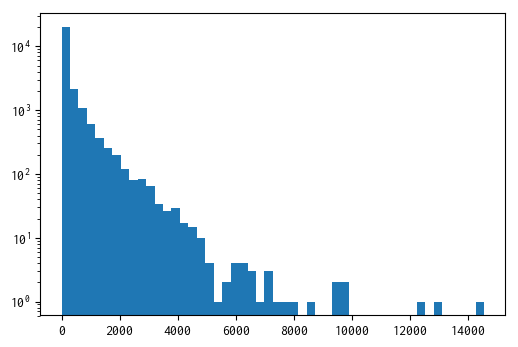

In [37]:
f, ax = plt.subplots(dpi=100)
plt.hist(num_possible_codes, bins=50, log=True);

This is a very large number of possible codes. The codebook is also big, but we use a large fraction of it. 

## How many codes are available for decoding? Given a codebook, how many would be expected to decode?

The seqfish codebook is a one-hot codebook with 12 channels $c$ and 5 rounds $r$. This means that each round can take on one of 12 values, and the formula to calculate the code space is $c^{r}$

Alternatively, if they view each individual (r, c) combination as a binary event, then the code space is $2^{r*c}$. Looking through their codebook, it appears that they are treating the hamming code in this way.

In [38]:
n_codes, n_channels, n_rounds = exp.codebook.shape

What fraction of spots should randomly decode? 

## $c^r$ space

This is how the authors are treating code space, if they only consider codes that decode. 

In [39]:
possible_codes = n_channels ** n_rounds
valid_code_space = n_codes / possible_codes
print(f"fraction of possible codes that are valid: {valid_code_space:.3f}")

fraction of possible codes that are valid: 0.042


Note that the authors allow a 1-hamming distance error. Correcting for allowing 1 error in each code position changes the formula to: 

In [40]:
with_hamming = n_codes * (n_rounds * (n_channels - 1))

hamming_code_space = with_hamming / possible_codes
print(f"fraction of possible codes that are valid in hamming code: {hamming_code_space:.3f}")

fraction of possible codes that are valid in hamming code: 2.303


This is more codes than are allowable in the code space, suggesting there are a substantial number of collisions, and thus they cannot use a hamming code in this form

## $2^{r*c}$ space

I think this is how the authors view their hamming space, which means that only some types of errors are allowable (an extra base could be "on" or a key base could be "off" but no base -> base transitions are allowed, since those are two binary actions)

In [441]:
possible_codes = 2 ** (n_rounds * n_channels)

In [442]:
n_codes / possible_codes

9.038776671577153e-15

Determine if the code is built in this way by checking the minimum hamming distances

In [419]:
from scipy.spatial.distance import pdist, squareform

codes = exp.codebook.stack(traces=('c', 'r')).values
distance_matrix = pdist(codes, metric='hamming')

distance_matrix = squareform(distance_matrix)
np.fill_diagonal(distance_matrix, 1)

_All_ codes have the following minimum hamming distance, which is too coincidental; Reasoning inductively, this is the way their code was built. 

In [443]:
np.unique(np.min(distance_matrix, axis=1), return_counts=True)[0] * (n_rounds * n_channels)

array([4.])

## What are the statistical properties of matching to the closest code **that decodes**?

Recall we built up the distances and indices for each spot, based on each round.

The next step is to reduce the lists of codes to those the closest codes that successfully decode in each round. 

The logical way to approach this would be to order codes by their distances and then decode them until a code is successfully decoded. The multiplicity of the code sizes makes a brute force solution potentially very slow. 

need functions to: 

1. Find all the possible codes
2. Find the distance of a code
3. check if each code decodes

Extra points if these approaches are vectorized, as the sequential look-up will potentially be very slow

In [67]:
# This is some boilerplate to add unique spot ids, and can be ignored

n_curr = 0
search_radius = 2.45

for table in per_round_spot_results.values():
    
    # make the index
    n = table.shape[0]
    ids = np.arange(n_curr, n_curr + n)
    
    # replace the index
    table.index = np.arange(n)
    table["spot_id"] = ids
    
    # increment the counter so each table has unique indices
    n_curr += n

In [45]:
dist, ind = match_spots_n_neighbors(per_round_spot_results, search_radius=2.45, anchor_round=1, n_neighbors=16)

exclude = dist > search_radius

We don't want to know the spot indices, we really want to know, for each round, what **channel** does the spot correspond to? To get at this, build a hash map to match spot ids to channels and map `ind`, the `spot_ids`, to their channels. 

In [46]:
# Map each spot to the channel it was detected in, forming a
# (round, spot, channel) array, where the channels correspond 
# to the nearest spots, and may contain duplicates

channel_data = np.empty_like(ind)
for round_ in np.arange(ind.shape[0]):
    linearized_indices = ind[round_].reshape(-1)
    per_round_channel_data = per_round_spot_results[round_]["c"]
    channel_ids = per_round_channel_data[linearized_indices].values
    channel_data[round_] = channel_ids.reshape(ind[round_].shape)

This is the set of channels that are within the search radius for spot 10000. The rows are the rounds, and the channels are sequentially more distant neighbors. 

Spots outside the search radius are masked by replacing them with -1

In [72]:
spot = 15000
masked = np.where(dist[:, spot, :] < search_radius, channel_data[:, spot, :], -1)
masked

array([[ 1,  4,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 7,  0, 10,  8,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 9,  0,  4,  6,  5, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 2,  1,  7, 11, 10, 10,  8, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
      dtype=int32)

Collapse to unique channels detected in each round

In [73]:
[set(row) - {-1, } for row in masked]

[{1, 4}, {0, 7}, {0, 1, 7, 8, 10}, {0, 4, 5, 6, 9}, {1, 2, 7, 8, 10, 11}]

Create a hash set for all the valid codes in the seqfish codebook for quick look ups later

In [74]:
valid_codes = set()
for code in exp.codebook.transpose("target", "r", "c"): 
    round_indices, channel_indices = np.where(code)
    valid_codes.add(tuple(channel_indices))

Write a function to find the codes that are: 
1. within 2.45 pixels
2. decode

In [75]:
from itertools import product

def get_codes(channels, dist_, search_radius):
    
    # returns the value for channels if the channel's distance is less than
    # search radius, otherwise returns -1
    masked = np.where(dist_ < search_radius, channels, -1)
    
    # per round, identifies the unique set of channels that are valid
    # (excludes -1)
    valid_channels_per_round = [set(row) - {-1, } for row in masked]
    
    # generator for all valid codes
    all_codes = product(*valid_channels_per_round)
    
    # list of codes that decode
    decodes = [code for code in all_codes if code in valid_codes]
    
    # iterate through the codes
    
    return decodes
    
    
def brute_force_code_check():
    pass

Worth leaving the below print out, since it shows how many possible codes there are that decode... Let's figure out what their distances are, next

In [76]:
test_channels = channel_data[:, 0, :]
test_distances = dist[:, 0, :]
decoded_test_codes = get_codes(test_channels, test_distances, search_radius)

Here there are quite a few possible codes that decode. 

In [77]:
decoded_test_codes

[(1, 0, 1, 8, 1),
 (1, 0, 1, 9, 2),
 (1, 0, 2, 1, 7),
 (1, 0, 2, 7, 1),
 (1, 0, 2, 8, 2),
 (1, 0, 3, 7, 2),
 (1, 0, 4, 0, 8),
 (1, 0, 4, 5, 1),
 (1, 0, 4, 9, 5),
 (1, 0, 5, 4, 1),
 (1, 0, 5, 5, 2),
 (1, 0, 5, 8, 5),
 (1, 0, 5, 10, 7),
 (1, 0, 7, 2, 1),
 (1, 0, 8, 5, 5),
 (1, 0, 8, 7, 7),
 (1, 0, 9, 4, 5),
 (1, 0, 9, 7, 8),
 (1, 0, 11, 5, 8),
 (2, 0, 0, 0, 5),
 (2, 0, 0, 2, 7),
 (2, 0, 0, 8, 1),
 (2, 0, 0, 9, 2),
 (2, 0, 1, 8, 2),
 (2, 0, 2, 7, 2),
 (2, 0, 2, 10, 5),
 (2, 0, 3, 0, 8),
 (2, 0, 3, 9, 5),
 (2, 0, 4, 8, 5),
 (2, 0, 5, 10, 8),
 (2, 0, 7, 1, 1),
 (2, 0, 7, 5, 5),
 (2, 0, 7, 8, 8),
 (2, 0, 8, 7, 8),
 (2, 0, 10, 5, 8),
 (2, 0, 11, 9, 1),
 (2, 0, 11, 10, 2),
 (4, 0, 0, 0, 7),
 (4, 0, 0, 1, 8),
 (4, 0, 0, 7, 2),
 (4, 0, 1, 5, 1),
 (4, 0, 1, 9, 5),
 (4, 0, 2, 4, 1),
 (4, 0, 2, 5, 2),
 (4, 0, 2, 10, 7),
 (4, 0, 3, 4, 2),
 (4, 0, 3, 9, 7),
 (4, 0, 4, 2, 1),
 (4, 0, 4, 8, 7),
 (4, 0, 5, 2, 2),
 (4, 0, 5, 8, 8),
 (4, 0, 7, 5, 7),
 (4, 0, 8, 2, 5),
 (4, 0, 8, 4, 7),
 (4, 0, 9, 4, 8),
 

I should pre-process these codes to get just the closest distance for each channel in each round... Here, the rounds can duplicate one another. For the time being I can write a really simple piece of code to:
1. find the minimum distance for each channel
2. find the distance for each code
3. identify the code that best matches
4. print out some statistics about the matching code

In [78]:
def get_closest_code(channels, dist_, search_radius):
    
    # returns the value for channels if the channel's distance is less than
    # search radius, otherwise returns -1
    masked = np.where(dist_ < search_radius, channels, -1)
    
    # per round, identifies the unique set of channels that are valid
    # (excludes -1)
    valid_channels_per_round = [set(row) - {-1, } for row in masked]
    
    # generator for all valid codes
    all_codes = list(product(*valid_channels_per_round))
    
    # list of codes that decode
    decodes = [code for code in all_codes if code in valid_codes]
    
    # find the closest distance for each (round, channel) pair
    distance_table: Mapping[Tuple[int, int], float] = {}
    for round_, channels in enumerate(valid_channels_per_round):
        for c in channels:
            channel_indices = np.where(masked[round_] == c)
            distance_table[round_, c] = np.min(dist_[round_, channel_indices])
    
    # calculate the distances for each decoding code, returning the closest code and the total number of codes checked
    rmse = lambda x: np.sqrt(sum(np.asarray(x) ** 2))
    distances = [rmse(code) for code in decodes]
        
    # find the smallest distance
    index = np.argmin(distances)
    closest_decoding_trace = decodes[index]
    distance = distances[index]
    
    # calculate distances for all codes
    all_distances = np.asarray([rmse(code) for code in all_codes])
    closest_trace = np.min(all_distances)
    fraction_closer_traces = np.sum(all_distances < distance) / all_distances.shape[0]
    
    # how many total traces are there? 
    total_traces = len(all_codes)
    
    # return: 
    # code
    # number of codes that decode
    # distance of the winning code
    # closest trace (including non-decoding codes)
    # fraction of traces that had lower distances
    # the total number of traces
    return closest_decoding_trace, len(decodes), distance, closest_trace, fraction_closer_traces, total_traces

Look at the top 10 traces

In [405]:
for i in range(10):
    test_channels = channel_data[:, i, :]
    test_distances = dist[:, i, :]
    print(f'code {i} data:')
    try:
        res = get_closest_code(test_channels, test_distances, search_radius)
        print(f"code: {res[0]}\tpossible (decoded) codes: {res[1]}\ndistance: {res[2]:.2f}\tclosest trace (may not decode): {res[3]:.2f}\npercentage of traces that were closer: {res[4]:.2f}\ttotal traces: {res[5]}")
    except ValueError:
        print('no codes decoded')

code 0 data:
code: (0, 0, 1, 1, 5)	possible (decoded) codes: 202
distance: 5.20	closest trace (may not decode): 1.00
percentage of traces that were closer: 0.03	total traces: 4950
code 1 data:
code: (8, 0, 2, 0, 1)	possible (decoded) codes: 4
distance: 8.31	closest trace (may not decode): 1.00
percentage of traces that were closer: 0.54	total traces: 72
code 2 data:
code: (2, 0, 5, 3, 1)	possible (decoded) codes: 62
distance: 6.24	closest trace (may not decode): 3.46
percentage of traces that were closer: 0.01	total traces: 1344
code 3 data:
no codes decoded
code 4 data:
code: (2, 0, 3, 2, 10)	possible (decoded) codes: 10
distance: 10.82	closest trace (may not decode): 7.00
percentage of traces that were closer: 0.13	total traces: 162
code 5 data:
code: (4, 0, 2, 5, 2)	possible (decoded) codes: 21
distance: 7.00	closest trace (may not decode): 2.83
percentage of traces that were closer: 0.14	total traces: 480
code 6 data:
code: (3, 0, 3, 4, 1)	possible (decoded) codes: 73
distance: 5.9

Recall we expect 4% of codes to decode by chance. How many do we see decoding here in the first trace? 

In [82]:
202 / 5000

0.0404

So, the next step would be to program the matching method across rounds and channels to verify that the same spots decode the same way across channels. However, looking at this mess, that's obviously not going to help: that just poses an objective function that says that there should be spatial separation between codes that decode. That's just a function of spot density, and could be easily randomly generated...

At this point I'm thinking "They must have meant I should truly just take the symmetric single nearest neighbors, as it's written". But I did that originally, got 4% barcodes decoding, and was told to do this instead, so I don't know what the fuck is going on. 

Also the pixel spot detector said this data is garbage, last time it ran successfully. 

## Match these traces back to data, visualize the results

Plot the circular images and the spots that are contained. 

Plot the closest code and the selected codes

## Conclusions

I can't have conclusions yet. 

Thoughts: 
- I've been working on a small amount of data
- I did something that seems reasonable that told me their small amount of data doesn't have signal
- I tried our other methods, that say the same thing
- I tried what they said to do, and it matches their text maybe? but is horribly statistically unprincipled and no one should ever do it
- Their coding stuff is a bit odd

Conclusions: 
1. I should run more data, perhaps a full field of view, using the per-round spot decoding capabilities of StarFISH. 
2. I should implement their spot detector
3. I should get them to give us results based on the small testing subset we have to verify that they do actually expect to see signal here. 

## Try to Process SeqFISH with per-round spot detection

Recall that the text of the intron-seqfish paper says something different and more reasonable than what's described above. Let's see if attempting to implement their wording does any better at calling more spots than would be expected by chance. Specifically, change the `LocalSearchBlobDetector` to examine only the set of spots that have the same residual spatial distance from the anchor position by picking the code that _decodes_.

Below is the workflow we'll implement. 

1. Detect spots in each volume
2. Combine the spots detected in all channels across a round
3. select one round as an "anchor" and use the physical coordinates of the spots detected in all channels in that round as seeds for barcode detection
4. Find the closest spot in each non-anchor round (within an outer bound "search radius") to each (z, y, x) spots from the anchor round, and build a code.
5. **If multiple point sets have the same spatial distance, use the codebook to resolve which barcode is correct**
6. **If multiple barcodes can still be matched to the codebook, drop the barcode**
7. **Repeat, using all rounds as anchor, and filter points that don't refer to the same code in 4/5 rounds.**
5. Return an `IntensityTable` containing the discovered codes. 

Note: I'm reloading data here because I tried to use per-round spot detection. It doesn't work yet to load the individual slices; right now you need to load the whole block and pull out the rounds after the data is already in memory. However, this _code_ should be reusable when we can pull out particular chunks without pre-loading the whole image stack. 

In [5]:
exp = starfish.Experiment.from_json('/Users/ajc/scratch/seqfish-test/experiment.json')
fov = exp.fov()
img = fov.get_image('primary')

100%|██████████| 1740/1740 [00:08<00:00, 205.39it/s]


Condense the data processing pipeline a bit. 

In [6]:
def scale_by_percentile(data, p=99.9):
    data = np.asarray(data)
    cval = np.percentile(data, p)
    data = data / cval
    data[data > 1] = 1
    return data


def seqfish_pipeline(img: np.ndarray):
    print('\tremoving background...')
    wth = starfish.image.Filter.WhiteTophat(masking_radius=3)
    img = wth.run(img, in_place=False)
        
    print('\tequalizing intensities...')
    img = img.apply(
        scale_by_percentile,
        group_by={Axes.ROUND, Axes.CH}, verbose=False, in_place=False
    )
    
    print('\tfinding spots...')
    lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
        min_sigma=(0.9, 0.9, 0.9),
        max_sigma=(5, 5, 5),
        num_sigma=7,
        threshold=0.1,
        anchor_round=0,  # we're always round zero if we're iterating through rounds
    )
    
    print('\tmerging spots by round...')
    per_tile_spot_results = lsbd._find_spots(
        img, 
        verbose=False, 
        n_processes=None,
    )
    
    per_round_spot_results = lsbd._merge_spots_by_round(per_tile_spot_results)
    
    return per_round_spot_results

Run the pipeline per round

In [7]:
rounds = np.asarray(img.xarray[Axes.ROUND.value])

In [8]:
spots = {}
for r in rounds:
    print(f"selecting sub-image for round {r}")
    subimg = img.sel({Axes.ROUND: r})
    spots[r] = seqfish_pipeline(subimg)
    print(f"round {r} completed")

selecting sub-image for round 0
	removing background...
	equalizing intensities...
	finding spots...
	merging spots by round...
round 0 completed
selecting sub-image for round 1
	removing background...
	equalizing intensities...
	finding spots...
	merging spots by round...
round 1 completed
selecting sub-image for round 2
	removing background...
	equalizing intensities...
	finding spots...
	merging spots by round...
round 2 completed
selecting sub-image for round 3
	removing background...
	equalizing intensities...
	finding spots...
	merging spots by round...
round 3 completed
selecting sub-image for round 4
	removing background...
	equalizing intensities...
	finding spots...
	merging spots by round...
round 4 completed


In [9]:
# add round information to the tables
for d in spots.values():
    for r, table in d.items():
        table[Axes.ROUND.value] = np.full(table.shape[0], fill_value=r)

# extract and merge the tables
tables = [spots[r][r] for r in rounds]
all_spots = pd.concat(tables, axis=0)

In [10]:
# give all spots a unique index by resetting and dropping the previous per-round indices
all_spots = all_spots.reset_index().drop('index', axis=1)

Update the previous code to work from the merged dataframe of spots, instead of dictionary of round-specific dataframes

In [11]:
from sklearn.neighbors import NearestNeighbors

def match_spots_n_neighbors(
    spots: pd.DataFrame, search_radius: int, anchor_round: int, 
    n_neighbors: int,
):
    """ For each spot in anchor round, find the closest n spots within search_radius in all rounds.

    Parameters
    ----------
    round_dataframes : Dict[int, pd.DataFrame]
        Output from _merge_spots_by_round, contains mapping of image volumes from each round to
        all the spots detected in them.
    search_radius : int
        The maximum (euclidean) distance in pixels for a spot to be considered matching in
        a round subsequent to the anchor round.
    anchor_round : int
        The imaging round to seed the local search from.

    Returns
    -------
    pd.DataFrame
        Spots x rounds dataframe containing the distances to the nearest spot. np.nan if
        no spot is detected within search radius
    pd.DataFrame
        Spots x rounds dataframe containing the indices of the nearest spot to the
        corresponding round_dataframe. np.nan if no spot is detected within search radius.

    """
    possible_rounds = np.unique(spots[Axes.ROUND.value])

    reference_df = spots.loc[spots[Axes.ROUND.value] == anchor_round]
    reference_coordinates = reference_df[[Axes.ZPLANE, Axes.Y, Axes.X]]

    dist = np.zeros((len(possible_rounds), reference_df.shape[0], n_neighbors), dtype=float)
    ind  = np.zeros((len(possible_rounds), reference_df.shape[0], n_neighbors), dtype=np.int32)

    # fill data for anchor round; every spot is a perfect match to itself.
    # this adds a single neighbor with distance zero corresponding to the anchor round spot_id
    ind[anchor_round, :, 0] = np.arange(reference_df.shape[0], dtype=np.int32)
    

    # get spots matching across rounds
    for r in sorted(set(possible_rounds) - {anchor_round, }):
        query_df = spots.loc[spots[Axes.ROUND.value] == r]
        query_coordinates = query_df[[Axes.ZPLANE, Axes.Y, Axes.X]]

        # Build the classifier; chose NN over radius neighbors because data structures are
        # amenable to vectorization, which improves execution time.
        # TODO ambrosejcarr use n_neighbors > 1 to break ties, enable codebook-based finding
        #      use additional axes in dist, ind to retain vectorization.
        nn = NearestNeighbors(n_neighbors=n_neighbors)
        nn.fit(query_coordinates)

        distances, indices = nn.kneighbors(reference_coordinates)
        dist[r] = distances
        ind[r] = indices

    return dist, ind

In [12]:
dist, ind = match_spots_n_neighbors(all_spots, search_radius=2.45, anchor_round=0, n_neighbors=10)

Make indices into channels again

In [13]:
channel_data = np.empty_like(ind)
for round_ in np.arange(ind.shape[0]):
    linearized_indices = ind[round_].reshape(-1)
    per_round_channel_data = all_spots.loc[all_spots[Axes.ROUND.value] == round_][Axes.CH.value]
    channel_ids = per_round_channel_data.iloc[linearized_indices].values
    channel_data[round_] = channel_ids.reshape(ind[round_].shape)

In [14]:
valid_codes = set()
for code in exp.codebook.transpose("target", "r", "c"): 
    round_indices, channel_indices = np.where(code)
    valid_codes.add(tuple(channel_indices))

From the distances and indices, build point sets, masking any spots that:

Need _two_ masks now instead of one:
* are greater than a certain search radius, 
* **have greater distance than the preceding spot**

In [15]:
import numpy.ma as ma

In [45]:
search_radius = 2.45

mask_radius = dist < search_radius

mask_diff = np.concatenate([np.full((dist.shape[0], dist.shape[1], 1), fill_value=True), np.isclose(np.cumsum(np.diff(dist, axis=2), axis=2), 0)], axis=2)

masked_ch = ma.masked_array(channel_data, ~(mask_diff & mask_radius))

masked_ind = ma.masked_array(ind, ~(mask_diff & mask_radius))

In [47]:
# reshape as (spots, rounds, neighbors)
masked_ch = masked_ch.transpose(1, 0, 2)

In [51]:
n_results = np.empty((len(masked_ch)), dtype=int)
n_tests = np.empty((len(masked_ch)), dtype=int)
for i, row in enumerate(masked_ch):

    channels_per_round = [np.unique(r.compressed()) for r in row]

    potential_codes = set(product(*channels_per_round))

    decoded = potential_codes.intersection(valid_codes)
    
    n_results[i] = len(decoded)
    n_tests[i] = len(potential_codes)
    
    if not i % 1000:
        print(f'{i} spots completed')

0 spots completed
1000 spots completed
2000 spots completed
3000 spots completed
4000 spots completed
5000 spots completed
6000 spots completed
7000 spots completed
8000 spots completed
9000 spots completed
10000 spots completed
11000 spots completed
12000 spots completed
13000 spots completed
14000 spots completed
15000 spots completed
16000 spots completed
17000 spots completed
18000 spots completed
19000 spots completed
20000 spots completed
21000 spots completed
22000 spots completed
23000 spots completed
24000 spots completed
25000 spots completed


How many point sets decode for each seed spot? Look at the empirical distribution

In [49]:
np.unique(n_results, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7, 32]),
 array([22078,  2771,   300,    45,    19,     5,     2,     2,     1]))

How many total codes decode? How many would we expect to decode in this scheme? 

In [149]:
p_decodes = exp.codebook.shape[0] / 12 ** 5

expected_codes = n_tests * p_decodes

print(f'observed_codes: {np.sum(n_results)}\nexpected_codes: {np.sum(expected_codes)}')

observed_codes: 3665
expected_codes: 3647.5510223765427


I recover about twice as many spots this way, but it's still right in line with expectations from random decoding if we control for the number of codes that are subject to decoding. 

In [50]:
np.sum(n_results == 1) / len(n_results)

0.10986004836855251

## Explore visualization of this type of local matching

Take a look at the data, does it look right, but I'm just doing something wrong? 

In [62]:
masked_ind = masked_ind.transpose(1, 0, 2)

In [151]:
def visualize_spots_within_search_radius(masked_ind, all_spots, spot_id):
    """
    Given a spot ID, visualize the spots across rounds and channels
    
    Generates a plot, whose rows are the rounds and columns are the channels, 
    plotting just the area in which spots are identified. The exact size of the 
    extracted regions will be determined by the search radius. 
    
    Pad the regions by 1 pixel in x and y
    
    """
    vis_spots = []
    for i, row in enumerate(masked_ind[j]):
        inds = np.unique(row.compressed())
        this_round = all_spots.loc[all_spots[Axes.ROUND.value] == i]
        vis_spots.append(this_round.iloc[inds, :])
    vis_spots = pd.concat(vis_spots, axis=0).drop(0)

    imax = np.max(vis_spots[["x", "y", "z"]])
    imin = np.min(vis_spots[["x", "y", "z"]])

    subimg = scaled.isel({
        Axes.X: (imin['x'] - 1, imax['x'] + 1), 
        Axes.Y: (imin['y'] - 1, imax['y'] + 1), 
        Axes.ZPLANE: (imin['z'] - 1, imax['z'] + 1), 
    })
    subimg = subimg.max_proj(Axes.ZPLANE)
    clim = np.percentile(flat, (0, 99.9))

    vmin, vmax = np.percentile(subimg.xarray.values, (0, 99))
    f, axes = plt.subplots(nrows=5, ncols=12)
    for r in range(5):
        for c in range(12):
            axes[r, c].imshow(subimg.xarray.sel(r=r, c=c).squeeze(), vmin=vmin, vmax=vmax)
            axes[r, c].set_axis_off()

100%|██████████| 60/60 [00:00<00:00, 283.44it/s]


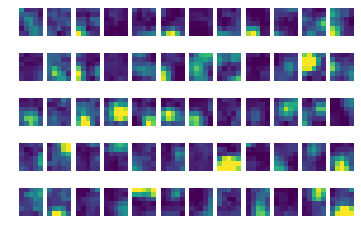

In [152]:
visualize_spots_within_search_radius(masked_ind, all_spots, 2)

No, it really does look like there are quite a few options for decoding. :\

## Implement the spot detector as defined, including the matching, so that we can at least say we've implemented it. 